In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp "drive/My Drive/Colab Notebooks/cracks/models.py" .
!cp "drive/My Drive/Colab Notebooks/cracks/losses.py" .
!cp "drive/My Drive/Colab Notebooks/cracks/utils.py" . -f
!cp "drive/My Drive/Colab Notebooks/cracks/dataset.csv" .

In [3]:
!pip install -U segmentation-models
!pip install albumentations

     |████████████████████████████████| 51kB 2.9MB/s 
     |████████████████████████████████| 634kB 9.1MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654021 sha256=7412b77d815c81383559737f7662cdc9691b6b25a9a9c2e8ab5a9d7a96b936f7
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [4]:
import os

import pandas as pd

import models
import losses
import utils
import json
from keras import callbacks

from matplotlib import pyplot as plt
from keras.optimizers import RMSprop, Adam
from sklearn.model_selection import train_test_split

import cv2 as cv
import glob
import numpy as np

In [5]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


# Обучение модели

In [6]:
#INPUT_SHAPE = (544, 1984, 1)
INPUT_SHAPE = (1056, 3936, 1)

CHECKPOINT_PATH = 'drive/My Drive/Colab Notebooks/cracks/model.h5'
PATH = '/content/drive/My Drive/Colab Notebooks/cracks/data/'


BATCH_SIZE = 1

In [7]:
'''
df = pd.read_csv('dataset.csv')
LEN_OF_DATASET = df.shape[0]
df.head()

for i in range(LEN_OF_DATASET):
  im = utils.get_image_by_url(df['Labeled Data'].to_list()[i],INPUT_SHAPE)

  label = utils.load_label(df['Label'].to_list()[i],INPUT_SHAPE)
  mask = utils.labels_to_rgb(label)
  mask = cv.cvtColor(mask, cv.COLOR_RGB2BGR)
  
  cv.imwrite(PATH+'images/{}.png'.format(i), im)
  cv.imwrite(PATH+'masks/{}.png'.format(i), mask)
  '''

"\ndf = pd.read_csv('dataset.csv')\nLEN_OF_DATASET = df.shape[0]\ndf.head()\n\nfor i in range(LEN_OF_DATASET):\n  im = utils.get_image_by_url(df['Labeled Data'].to_list()[i],INPUT_SHAPE)\n\n  label = utils.load_label(df['Label'].to_list()[i],INPUT_SHAPE)\n  mask = utils.labels_to_rgb(label)\n  mask = cv.cvtColor(mask, cv.COLOR_RGB2BGR)\n  \n  cv.imwrite(PATH+'images/{}.png'.format(i), im)\n  cv.imwrite(PATH+'masks/{}.png'.format(i), mask)\n\n\n\ntest_idxs = [21, 65, 75, 100]\ntest_blur_contr = df.iloc[test_idxs]\ndf.drop(test_idxs, inplace = True)\n\n_, val = train_test_split(df[:422], test_size=0.2, random_state=666)\ntrain = df[~df.ID.isin(val.ID)]\nX_train = train['Labeled Data']\ny_train = train['Label']\nX_test = val['Labeled Data']\ny_test = val['Label']\n  "

## Разбиение данных на тест и проверку

In [8]:
x_paths = sorted(glob.glob(PATH+'images/*.png'))
y_paths = sorted(glob.glob(PATH+'masks/*.png'))

paths = list(zip(x_paths,y_paths))

train, val = train_test_split(paths, test_size=0.2, random_state=666)

## Список преобразований, которые позволяют расширить датасет

In [9]:
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma, OneOf, ShiftScaleRotate
)

from albumentations.augmentations.transforms import Blur
one_of =OneOf([
           RandomContrast(limit=0.4, p=0.5), 
           RandomBrightness(limit=0.5, p=0.5) 
           ],p=1)
augs = Compose([
                    HorizontalFlip(p=0.5),
                    VerticalFlip(p=0.5),
                    one_of,
                    Blur(blur_limit=5, p=0.1),
                    ShiftScaleRotate(shift_limit=0.2, scale_limit=0.4, rotate_limit=0, p=0.3)
                    
                    #RandomGamma(gamma_limit=(80, 120), p=0.2),

    ])

## Инициализация генераторов данных

In [11]:
train_gen = utils.DataGenerator(train, 1, INPUT_SHAPE, augs)
val_gen = utils.DataGenerator(val, 1, INPUT_SHAPE, None)

## Инициализация модели
  В качестве функции потерь используется коэффицент Дайса, тк он более чувствителен к несбалансированным датасетам, также для балансировки классов используются веса классов.

In [12]:
#model = unet.simple_unet(INPUT_SHAPE2, CHECKPOINT_PATH)
class_weights = [.15, .25, .6] 
#class_weights = [.10, .33, .57]

model = sm.Unet('resnet18',input_shape=INPUT_SHAPE,activation='softmax',encoder_weights=None, classes=3)#, decoder_filters=(256, 128, 64, 32, 16))
#model = sm.PSPNet('resnet34', input_shape=INPUT_SHAPE2, classes=3, activation='softmax', encoder_weights=None, downsample_factor=16, psp_conv_filters=32, psp_dropout=0.2)
#model = models.Unet(INPUT_SHAPE2, 3, filters=(4, 8, 16, 32))
#learning_rate=4e-3
model.compile(RMSprop(), loss=sm.losses.DiceLoss(), metrics = [sm.metrics.IOUScore(), sm.metrics.f1_score])
#model.load_weights(CHECKPOINT_PATH)

## Обучение модели

In [13]:
h = model.fit(train_gen, validation_data=val_gen, epochs=30 ,steps_per_epoch=len(train_gen),
                  validation_steps=len(val_gen),
                  callbacks=[
                      callbacks.ModelCheckpoint(
                          filepath=CHECKPOINT_PATH,
                          monitor='val_loss',
                          mode='min',
                          save_best_only=True,
                          save_weights_only=True
                      ),
                      callbacks.EarlyStopping(
                          monitor='loss',
                          patience=4,
                          mode='min'
                      ),
                      callbacks.ReduceLROnPlateau(
                          patience=0,
                          monitor='loss',
                          mode='min',
                          factor=0.1
                      )
                  ]).history

Epoch 1/30
442/442 [==============================] - 1558s 4s/step - loss: 0.5318 - iou_score: 0.4369 - f1-score: 0.4682 - val_loss: 0.6032 - val_iou_score: 0.3539 - val_f1-score: 0.3968
Epoch 2/30
442/442 [==============================] - 261s 590ms/step - loss: 0.4848 - iou_score: 0.4843 - f1-score: 0.5152 - val_loss: 0.4803 - val_iou_score: 0.4784 - val_f1-score: 0.5197
Epoch 3/30
442/442 [==============================] - 259s 587ms/step - loss: 0.4738 - iou_score: 0.4947 - f1-score: 0.5262 - val_loss: 0.5849 - val_iou_score: 0.3639 - val_f1-score: 0.4151
Epoch 4/30
442/442 [==============================] - 254s 575ms/step - loss: 0.4686 - iou_score: 0.5002 - f1-score: 0.5314 - val_loss: 0.5743 - val_iou_score: 0.3848 - val_f1-score: 0.4257
Epoch 5/30
442/442 [==============================] - 252s 570ms/step - loss: 0.4655 - iou_score: 0.5055 - f1-score: 0.5345 - val_loss: 0.4771 - val_iou_score: 0.4844 - val_f1-score: 0.5229
Epoch 6/30
442/442 [==============================] 

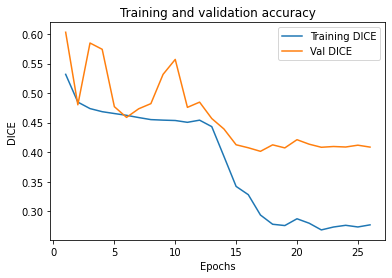

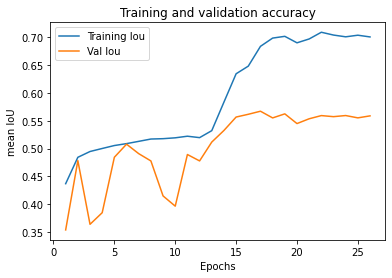

In [14]:
# График с историей обученичения
plt.plot(range(1, len(h['loss']) + 1), h['loss'], label='Training DICE')
plt.plot(range(1, len(h['val_loss']) + 1), h['val_loss'], label='Val DICE')
plt.xlabel('Epochs')
plt.ylabel('DICE')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()    

plt.plot(range(1, len(h['iou_score']) + 1), h['iou_score'], label='Training Iou')
plt.plot(range(1, len(h['val_iou_score']) + 1), h['val_iou_score'], label='Val Iou')
plt.xlabel('Epochs')
plt.ylabel('mean IoU')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()    
